# Classifying MNIST with Random-Weight Features
The MNIST dataset is a common "benchmark" dataset for deep learning tutorials and research, e.g. exploring new network architectures and network elements. However, the dataset itself is unsuitable for this task as it is too trivial. In this notebook, I show that classifying the digits of this dataset with a deep convolutional neural network (DCNN) is essentially a trivial task. For this, I compare the classification accuracy of a conventionally trained DCNN to the features extracted by an untrained, i.e. randomly initialized, DCNN. This comparison will highlight that training a neural network is unnecessary to accurately differentiate MNIST digits.

Deep neural networks can be interpreted as consisting of two parts: feature extraction and classification/regression. The assignment of layers to roles is open to interpretation, but a simple interpretation is that the final output layer is the classification/regression layer and all hidden layers between input and output are responsible for feature extraction.

![Hidden Layers](dnn_hidden_layers.png)
<center>Image taken from <a href="https://towardsdatascience.com/applied-deep-learning-part-1-artificial-neural-networks-d7834f67a4f6">TowardsDataScience</a></center>

DCNNs, in particular, can be interpreted as extracting hierarchical features of increasing complexity with convolutional and pooling layers that are then classified/regressed on in the final, fully connected output layers.

![Hierarchical Features](dcnn_feature_extraction.png)
<center>Image adapted from <a href="https://www.analyticsvidhya.com/blog/2017/04/comparison-between-deep-learning-machine-learning/">AnalyticsVidhya</a></center>

## Imports

In [1]:
import keras
import keras.models as kmod
import keras.layers as klay
import keras.utils as kutils
import numpy as np
import sklearn.ensemble
import sklearn.preprocessing
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Load Data

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Min-Max Scaling
train_min = np.min(x_train, axis=(1, 2))[:, np.newaxis, np.newaxis]
train_max = np.max(x_train, axis=(1, 2))[:, np.newaxis, np.newaxis]
x_train = (x_train - train_min) / (train_max - train_min)
test_min = np.min(x_test, axis=(1, 2))[:, np.newaxis, np.newaxis]
test_max = np.max(x_test, axis=(1, 2))[:, np.newaxis, np.newaxis]
x_test = (x_test - test_min) / (test_max - test_min)

# Transform labels
y_train_cat = kutils.to_categorical(y_train)
y_test_cat = kutils.to_categorical(y_test)

# Transform input to be 4D
x_train = x_train[..., None]
x_test = x_test[..., None]

## Conventional DCNN with Training
For the first step, a generic DCNN is constructed and all layers are included in the training. The network architecture chosen here has no deeper meaning and was chosen for its simplicity. Furthermore, this is not meant to be a study in best practices as I only wish to highlight the importance of training the feature extraction layers.

The network is validated on the test subset of the MNIST dataset, which is not included during the training.

In [3]:
# create model
model = kmod.Sequential()

# add model layers
model.add(klay.Conv2D(
    filters=32, kernel_size=3, activation='relu', 
    input_shape=x_train.shape[1:]))
model.add(klay.MaxPool2D())
model.add(klay.Conv2D(
    filters=32, kernel_size=3, activation='relu', 
    kernel_initializer="glorot_uniform"))
model.add(klay.MaxPool2D())
model.add(klay.Conv2D(
    filters=32, kernel_size=3, activation='relu', 
    kernel_initializer="glorot_uniform"))
model.add(klay.Flatten())
model.add(klay.Dense(
    units=10, activation='softmax', 
    kernel_initializer="glorot_uniform"))

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train_cat, validation_data=(x_test, y_test_cat), epochs=5, verbose=2)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
 - 30s - loss: 0.1837 - acc: 0.9446 - val_loss: 0.0675 - val_acc: 0.9785
Epoch 2/5
 - 26s - loss: 0.0586 - acc: 0.9817 - val_loss: 0.0491 - val_acc: 0.9840
Epoch 3/5
 - 29s - loss: 0.0432 - acc: 0.9869 - val_loss: 0.0398 - val_acc: 0.9874
Epoch 4/5
 - 30s - loss: 0.0361 - acc: 0.9889 - val_loss: 0.0410 - val_acc: 0.9867
Epoch 5/5
 - 30s - loss: 0.0296 - acc: 0.9909 - val_loss: 0.0360 - val_acc: 0.9881


The network is, as expected, extremely accurate in classifying handwritten digits.

In [4]:
cnn_acc = model.evaluate(x=x_test, y=y_test_cat, verbose=False)
print("Trained CNN Accuracy = {}%".format(np.round(cnn_acc[1]*100, 2)))

Trained CNN Accuracy = 98.81%


## Extracting Features with Random Network Weights
In this second step, only the final classification layer is trained. All hidden layers are randomly initialized (Glorot uniform initialization with default parameters) and kept that way. This network will be trained and evaluated several times to identify the stability of these random-weight features.

Note that this is essentially an [Extreme Learning Machine](https://en.wikipedia.org/wiki/Extreme_learning_machine).

In [5]:
random_feature_accuracies = []
random_feature_models = []

for ii in range(10):
    # create model
    model = kmod.Sequential()

    # add model layers
    model.add(klay.Conv2D(
        filters=32, kernel_size=3, activation='relu', 
        input_shape=x_train.shape[1:], 
        trainable=False))
    model.add(klay.MaxPool2D(trainable=False))
    model.add(klay.Conv2D(
        filters=32, kernel_size=3, activation='relu', 
        kernel_initializer="glorot_uniform", 
        trainable=False))
    model.add(klay.MaxPool2D(trainable=False))
    model.add(klay.Conv2D(
        filters=32, kernel_size=3, activation='relu', 
        kernel_initializer="glorot_uniform", 
        trainable=False))
    model.add(klay.Flatten(trainable=False))
    model.add(klay.Dense(
        units=10, activation='softmax', 
        kernel_initializer="glorot_uniform"))

    # compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(x_train, y_train_cat, validation_data=(x_test, y_test_cat), epochs=5, verbose=0)
    random_feature_accuracies.append(model.evaluate(x=x_test, y=y_test_cat, verbose=0)[1])
    random_feature_models.append(model)

The accuracy of the partially trained DCNN is slightly worse than that of the fully trained network but very stable across iterations.

In [6]:
print("Random Feature Accuracy = ({} +/- {})%".format(
    np.round(np.mean(random_feature_accuracies)*100, 2), 
    np.round(np.std(random_feature_accuracies)*100, 2)))

Random Feature Accuracy = (91.49 +/- 0.5)%


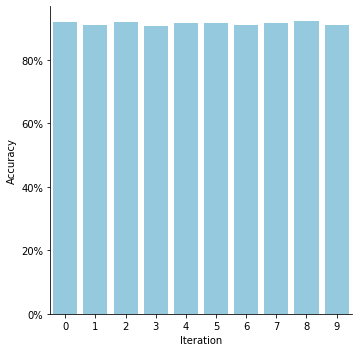

In [7]:
random_feature_accuracies_df = pd.DataFrame({
    "Iteration": range(10), 
    "Accuracy": random_feature_accuracies})
myFigure = sns.catplot(
    x="Iteration", y="Accuracy", data=random_feature_accuracies_df, 
    kind="bar", color="skyblue");
myFigure.ax.yaxis.set_major_formatter(
    plt.FuncFormatter(lambda num, tick_num: "{:.0f}%".format(num*100)))

### Alternative Classifiers
The single-layer classification step is relatively simple. We can also look at what happens if we classify the random-weight features, extracted from the second-to-last layer of the DCNN above, with a more sophisticated method such as a random forest.

In [8]:
random_features = []
random_feature_forest_accs = []

for model in random_feature_models:
    # Extract features from submodel
    submodel = kmod.Sequential(layers=model.layers[:-1])
    features_train = submodel.predict(x_train)
    features_test = submodel.predict(x_test)
    random_features.append([features_train, features_test])
    
    # Random forest model
    rf = sklearn.ensemble.RandomForestClassifier(n_estimators=100)
    rf.fit(X=features_train, y=y_train)
    random_feature_forest_accs.append(rf.score(X=features_test, y=y_test))

A random forest evaluated on the test data exhibits a high accuracy across all iterations.

In [9]:
print("Random Forest Accuracy on Random-Weight Features = ({} +/- {})%".format(
    np.round(np.mean(random_feature_forest_accs)*100, 2), 
    np.round(np.std(random_feature_forest_accs)*100, 2)))

Random Forest Accuracy on Random-Weight Features = (95.33 +/- 0.23)%


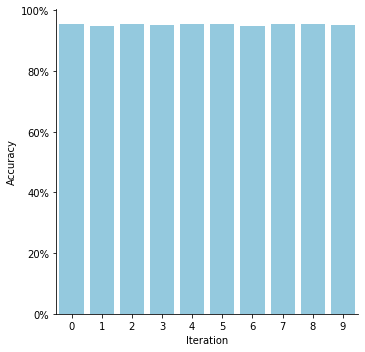

In [10]:
random_feature_forest_accs_df = pd.DataFrame({
    "Iteration": range(10), 
    "Accuracy": random_feature_forest_accs})
myFigure = sns.catplot(
    x="Iteration", y="Accuracy", data=random_feature_forest_accs_df, 
    kind="bar", color="skyblue");
myFigure.ax.yaxis.set_major_formatter(
    plt.FuncFormatter(lambda num, tick_num: "{:.0f}%".format(num*100)))

#### Unsupervised Clustering
Unsupervised clustering of the mean features shows a very clear separation of the individual classes. For this clustering, I used [t-Distributed Stochastic Neighbor Embedding (t-SNE)](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding). This method is well-suited to visualize clustering behaviour in high dimensions but this comes at the cost of a strong dependence on the parameters. This section serves only to visualize that random-weight features *can* be clustered, not to analyze the clustering behaviour itself.

In [11]:
# Average test features over all iterations
all_test_features = np.mean(np.stack([s[1] for s in random_features]), axis=0)
all_train_features = np.mean(np.stack([s[0] for s in random_features]), axis=0)

In [12]:
# Compute t-SNE
import sklearn.manifold
tsne_features = sklearn.manifold.TSNE().fit_transform(X=all_test_features)
tsne_features = pd.DataFrame(tsne_features, columns=("X", "Y"))
tsne_features["Label"] = y_test
tsne_features["Label"] = tsne_features["Label"].astype("str")

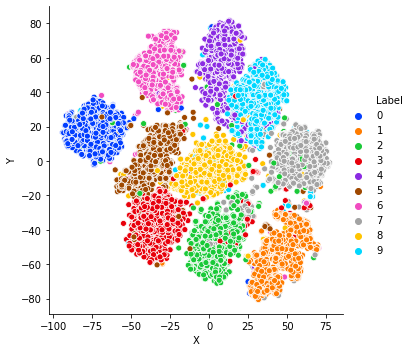

In [13]:
sns.relplot(
    data=tsne_features, x="X", y="Y", hue="Label",
    palette=sns.color_palette(palette="bright", n_colors=10))

## Conclusion
I have shown that initializing a neural network with random weights and subsequently training only the final output layer sufficiently classifies the MNIST handwritten digits. Simply training the final layer results in accuracies of $\sim 90\%$, far greater than what would be expected of random guessing ($\sim 10\%$), while a non-parametric, random forest classifier trained on the random-weight features will exhibit nearly equivalent accuracy as the fully trained DCNN ($\sim 95\%$) while requiring only a fraction of the training time.

These results indicate that the MNIST dataset is too trivial to serve as a benchmark dataset. Any conclusions drawn from this dataset most likely reflect this triviality more than the power of the research matter, e.g. network architectures or novel network elements.